### Load trained model

c:\Users\ensli\anaconda3\envs\env_pytorch\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Returned masks shape: (9, 1024, 1024)
GT mask unique: [-1  0  1  2  3  4  5  6  7  8]


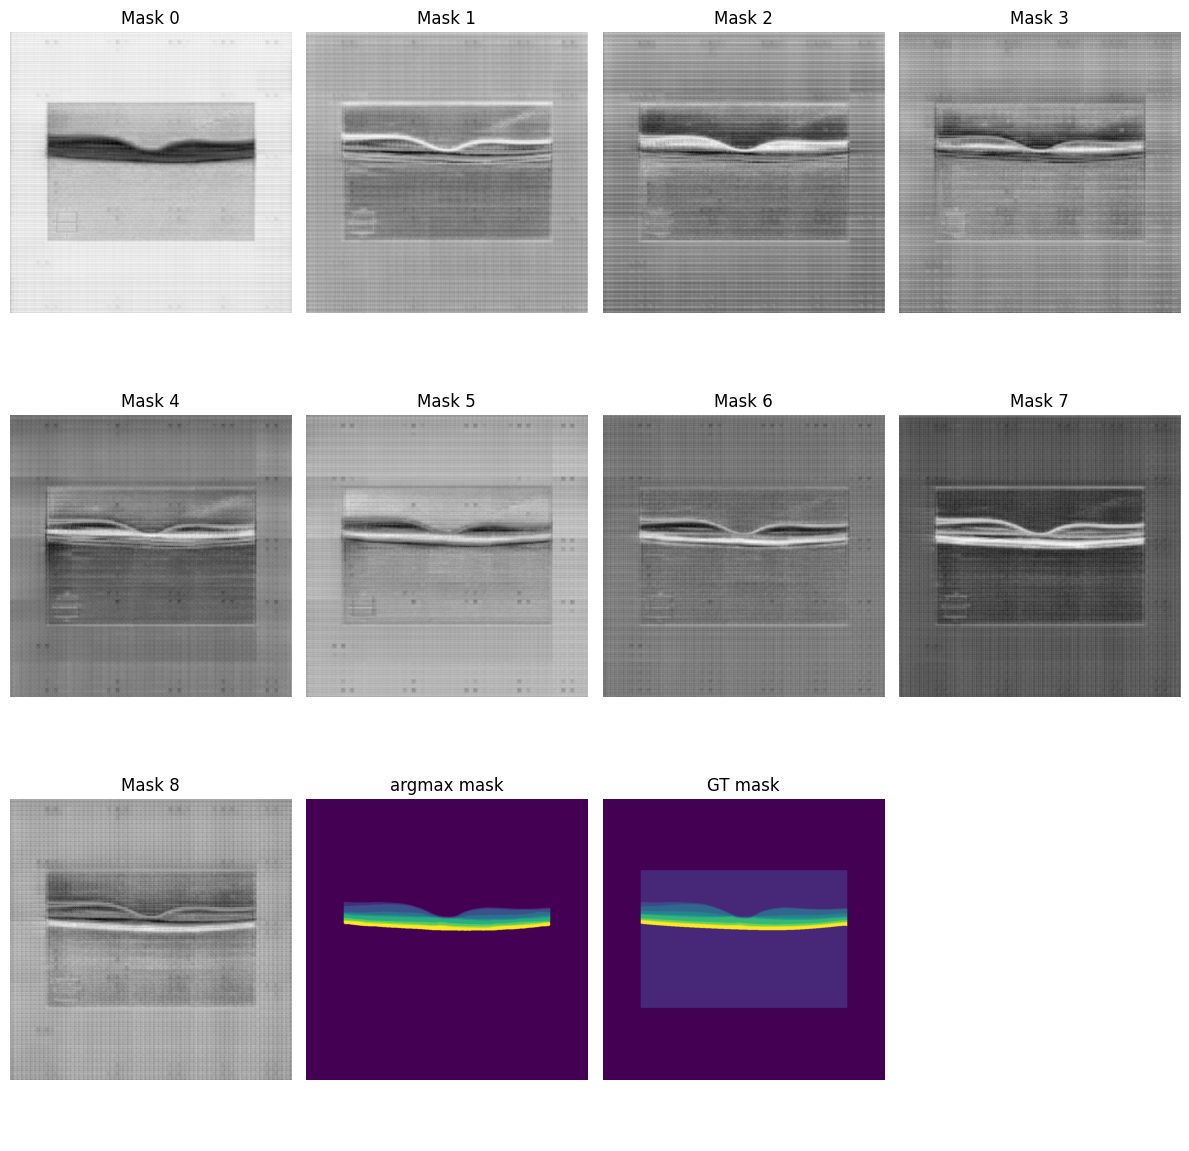

In [2]:
from torch.utils.data import DataLoader
from pathlib import Path
import torch
import numpy as np
import matplotlib.pyplot as plt

from setup_imports import root_dir
from semantic_sam2.build_semantic_sam2 import build_semantic_sam2
from semantic_sam2.train_semantic_sam2 import PairedImageMaskDataset, forward_semantic_logits

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
pin_memory = device.type == "cuda"

hydra_overrides = [
    "++model._target_=semantic_sam2.semantic_sam2_components.SAM2Semantic",
    f"++model.num_classes={9}",
    "++model.num_maskmem=0",
    "++model.use_mask_input_as_output_without_sam=false",
    "++model.multimask_output_in_sam=false",
    "++model.pred_obj_scores=false",
    "++model.pred_obj_scores_mlp=false",
    "++model.fixed_no_obj_ptr=false",
]

sam2_checkpoint = root_dir/"semantic_sam2/training_checkpoints/test_run8_R2_endBest.pt"
# sam2_checkpoint =root_dir/"checkpoints/sam2.1_hiera_base_plus.pt"

model = build_semantic_sam2(
    config_file="configs/sam2.1/sam2.1_hiera_b+.yaml",
    ckpt_path=str(sam2_checkpoint),
    device=str(device),
    mode="eval",
    hydra_overrides_extra=hydra_overrides,
    apply_postprocessing=False,
    use_load_checkpoint_staged_safe=True,
)

model.num_maskmem = 0
model.use_mask_input_as_output_without_sam = False

dataset = PairedImageMaskDataset(
    image_dir=Path(r"D:\GitHub\segment_anything_private\processed_data\Healthy\val\img_unchanged"),
    mask_dir=Path(r"D:\GitHub\segment_anything_private\processed_data\Healthy\val\mask_unchanged"),
    image_size=model.image_size,
    num_classes=9,
    ignore_index=-1,
    augment=False,
    pad_only=True,
    pad_center=True
)

data_loader = DataLoader(
    dataset,
    batch_size=1,
    shuffle=False,
    num_workers=0,
    pin_memory=pin_memory,
    drop_last=False,
)

data_iter = iter(data_loader)
batch = next(data_iter)

images = batch["image"].to(device, non_blocking=True)


mask_prediction = forward_semantic_logits(model, images)

masks = mask_prediction.squeeze(0).detach().cpu().numpy()
print(f"Returned masks shape: {masks.shape}")


# assume masks.shape = (9, 1200, 1800)
argmax_mask = np.argmax(masks, axis=0)  # shape: (H, W)
GT_mask=batch["mask"][0]
print(f"GT mask unique: {np.unique(GT_mask)}")

fig, axes = plt.subplots(3, 4, figsize=(12, 12))  # 3x4 grid
axes = axes.flatten()

for i in range(9):
    axes[i].imshow(masks[i], cmap="gray")
    axes[i].set_title(f"Mask {i}")
    axes[i].axis("off")
axes[9].imshow(argmax_mask)
axes[9].set_title("argmax mask")
axes[9].axis("off")
axes[10].imshow(GT_mask)
axes[10].set_title("GT mask")
axes[10].axis("off")
axes[11].axis("off")

plt.tight_layout()
plt.show()

### Use model to precompute and save predicted masks

In [1]:
from torch.utils.data import DataLoader
from pathlib import Path
import torch
import numpy as np
import matplotlib.pyplot as plt

from setup_imports import root_dir
from semantic_sam2.build_semantic_sam2 import build_semantic_sam2
from semantic_sam2.train_semantic_sam2 import PairedImageMaskDataset, forward_semantic_logits


PRED_SAVE_DIR = root_dir / "semantic_sam2" / "pred_cache" / "val_preds_run8_R2"
sam2_checkpoint = root_dir/"semantic_sam2/training_checkpoints/test_run8_R2_endBest.pt"
# sam2_checkpoint =root_dir/"checkpoints/sam2.1_hiera_base_plus.pt"


PRED_SAVE_DIR.mkdir(parents=True, exist_ok=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
pin_memory = device.type == "cuda"

hydra_overrides = [
    "++model._target_=semantic_sam2.semantic_sam2_components.SAM2Semantic",
    f"++model.num_classes={9}",
    "++model.num_maskmem=0",
    "++model.use_mask_input_as_output_without_sam=false",
    "++model.multimask_output_in_sam=false",
    "++model.pred_obj_scores=false",
    "++model.pred_obj_scores_mlp=false",
    "++model.fixed_no_obj_ptr=false",
]

model = build_semantic_sam2(
    config_file="configs/sam2.1/sam2.1_hiera_b+.yaml",
    ckpt_path=str(sam2_checkpoint),
    device=str(device),
    mode="eval",
    hydra_overrides_extra=hydra_overrides,
    apply_postprocessing=False,
    use_load_checkpoint_staged_safe=True,
)

model.num_maskmem = 0
model.use_mask_input_as_output_without_sam = False

dataset = PairedImageMaskDataset(
    image_dir=Path(r"D:\GitHub\segment_anything_private\processed_data\Healthy\val\img_unchanged"),
    mask_dir=Path(r"D:\GitHub\segment_anything_private\processed_data\Healthy\val\mask_unchanged"),
    image_size=model.image_size,
    num_classes=9,
    ignore_index=-1,
    augment=False,
    pad_only=True,
    pad_center=True
)

data_loader = DataLoader(
    dataset,
    batch_size=4,
    shuffle=False,
    num_workers=0,
    pin_memory=pin_memory,
    drop_last=False,
)

data_iter = iter(data_loader)


with torch.no_grad():
    model.eval()
    # manifest = []
    for batch in data_iter:
        images = batch["image"].to(device, non_blocking=True)
        mask_predictions = forward_semantic_logits(model, images)

        GT_masks_np = batch['mask'].detach().cpu().numpy()
        images_np =  batch['unNorm_image'].permute(0,2,3,1).detach().cpu().numpy()
        mask_predictions_np = mask_predictions.detach().cpu().numpy()
        img_paths = batch['image_path']
        mask_paths = batch['mask_path']

        for k, prediction in enumerate(mask_predictions_np):
            argmax_prediction = np.argmax(prediction, axis=0)
            img_path = img_paths[k]
            mask_path = mask_paths[k]
            stem = Path(img_path).stem
            save_path = PRED_SAVE_DIR / f"{stem}.npz"

            to_save = {
                "pred": argmax_prediction,                                  # H×W, uint8
                "gt": GT_masks_np[k],                                # H×W, int32 or None
                "image": images_np[k],                                      # HxWx3
                "ignore_index": np.int32(-1),
                "image_path": img_path,
                "mask_path": mask_path,
            }

            np.savez_compressed(save_path, **to_save)



c:\Users\ensli\anaconda3\envs\env_pytorch\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Evaluate model performance

- Load precomputed masks

Class                 Support         TP         FP         FN     Prec      Rec      IoU     Dice
--------------------------------------------------------------------------------------------------
Class 0              12759727   12713694      10202      46033    0.999    0.996    0.996    0.998
Class 1                139227     127035      40123      12192    0.760    0.912    0.708    0.829
Class 2                509097     455184      32141      53913    0.934    0.894    0.841    0.914
Class 3                276256     239351      55367      36905    0.812    0.866    0.722    0.838
Class 4                156851     110735      42823      46116    0.721    0.706    0.555    0.713
Class 5                495556     420494      22095      75062    0.950    0.849    0.812    0.896
Class 6                192867     180096      49951      12771    0.783    0.934    0.742    0.852
Class 7                 96833      84852      49371      11981    0.632    0.876    0.580    0.734
Class 8   

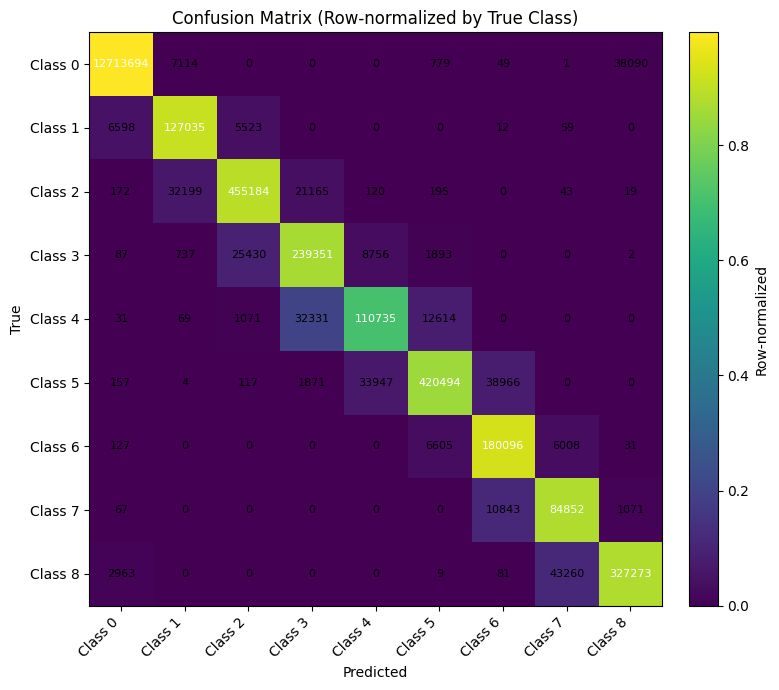

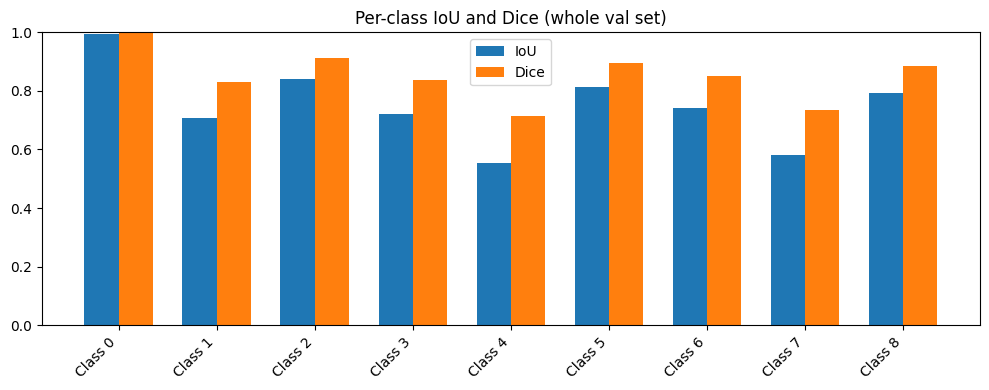


Top confusions per true class (excluding correct):
- Class 0 → Class 8 (38090), Class 1 (7114), Class 5 (779)
- Class 1 → Class 0 (6598), Class 2 (5523), Class 7 (59)
- Class 2 → Class 1 (32199), Class 3 (21165), Class 5 (195)
- Class 3 → Class 2 (25430), Class 4 (8756), Class 5 (1893)
- Class 4 → Class 3 (32331), Class 5 (12614), Class 2 (1071)
- Class 5 → Class 6 (38966), Class 4 (33947), Class 3 (1871)
- Class 6 → Class 5 (6605), Class 7 (6008), Class 0 (127)
- Class 7 → Class 6 (10843), Class 8 (1071), Class 0 (67)
- Class 8 → Class 7 (43260), Class 0 (2963), Class 6 (81)


In [2]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from PIL import Image


PRED_SAVE_DIR = root_dir / "semantic_sam2" / "pred_cache" / "val_preds_run8_R2"

NUM_CLASSES   = 9
IGNORE_INDEX  = -1
CLASS_NAMES   = None  # e.g., ["BG","NFL","GCL+IPL","INL","OPL","ONL","ELM+IS+OS","RPE","Choroid"]
N_OVERLAYS    = 6     # how many example overlays to show

def iter_cached_preds(pred_dir: Path):
    for npz_path in sorted(pred_dir.glob("*.npz")):
        data = np.load(npz_path, allow_pickle=True)
        yield {"file": str(npz_path)}, data


# Accumulators
K = NUM_CLASSES
cm_total = np.zeros((K, K), dtype=np.int64)
pixel_valid_total = 0
example_overlays = []  # hold a few (pred, gt) pairs for visualization


def name_or_id(i):
    return (CLASS_NAMES[i] if CLASS_NAMES and i < len(CLASS_NAMES) else f"Class {i}")

for rec, data in iter_cached_preds(PRED_SAVE_DIR):
    pred = data["pred"].astype(np.int64)          # H×W
    gt   = data["gt"].astype(np.int64)

    # If you saved IGNORE_INDEX per-file:
    if "ignore_index" in data.files:
        IGNORE_INDEX = int(data["ignore_index"])
    else:
        IGNORE_INDEX = -1

    gt_mask = gt

    # Predict
    pred_argmax = pred
    H_pred, W_pred = pred_argmax.shape

    if gt_mask.shape != (H_pred, W_pred):
        print("mask and prediction shapes dont match")
        break

    # Build valid mask (ignore = -1 or NaN)
    ignore_mask = (gt_mask == IGNORE_INDEX) | np.isnan(gt_mask)
    valid = ~ignore_mask
    gt_valid   = gt_mask[valid].astype(np.int64)
    pred_valid = pred_argmax[valid].astype(np.int64)

    # Update confusion matrix with bincount
    if gt_valid.size:
        flat = gt_valid * K + pred_valid
        counts = np.bincount(flat, minlength=K*K)
        cm_total += counts.reshape(K, K)
        pixel_valid_total += gt_valid.size

        # Keep a few examples for overlay
        if len(example_overlays) < N_OVERLAYS:
            # load raw image from path saved in npz
            img_uint8 = data['image']

            example_overlays.append((img_uint8, gt.copy(), pred_argmax.copy()))


# ---- Metrics from accumulated confusion matrix ----
eps = 1e-9
TP = np.diag(cm_total).astype(np.float64)
FP = cm_total.sum(axis=0) - TP
FN = cm_total.sum(axis=1) - TP
TN = cm_total.sum() - (TP + FP + FN)

support   = cm_total.sum(axis=1).astype(np.int64)
precision = TP / (TP + FP + eps)
recall    = TP / (TP + FN + eps)
iou       = TP / (TP + FP + FN + eps)
dice      = 2*TP / (2*TP + FP + FN + eps)
acc_cls   = (TP + TN) / (TP + FP + FN + TN + eps)

mask_sup  = support > 0
mean_iou     = np.mean(iou[mask_sup])  if mask_sup.any() else np.nan
mean_dice    = np.mean(dice[mask_sup]) if mask_sup.any() else np.nan
global_acc   = TP.sum() / max(pixel_valid_total, 1)

# ---- Print table ----
header = f"{'Class':<18} {'Support':>10} {'TP':>10} {'FP':>10} {'FN':>10} {'Prec':>8} {'Rec':>8} {'IoU':>8} {'Dice':>8}"
print(header)
print("-"*len(header))
for c in range(K):
    print(f"{name_or_id(c):<18} {support[c]:>10d} {int(TP[c]):>10d} {int(FP[c]):>10d} {int(FN[c]):>10d} "
          f"{precision[c]:>8.3f} {recall[c]:>8.3f} {iou[c]:>8.3f} {dice[c]:>8.3f}")
print("-"*len(header))
print(f"{'GLOBAL ACC':<18} {pixel_valid_total:>10d} {'':>10} {'':>10} {'':>10} "
      f"{'':>8} {'':>8} {mean_iou:>8.3f} {mean_dice:>8.3f}")
print(f"Pixel accuracy (valid only): {global_acc:.4f}")

# ---- Confusion matrix heatmap (row-normalized) ----
row_sums = cm_total.sum(axis=1, keepdims=True)
cm_norm = cm_total / np.clip(row_sums, 1, None)

fig, ax = plt.subplots(figsize=(8, 7))
im = ax.imshow(cm_norm, interpolation="nearest")
ax.set_title("Confusion Matrix (Row-normalized by True Class)")
ax.set_xlabel("Predicted")
ax.set_ylabel("True")
ax.set_xticks(np.arange(K)); ax.set_yticks(np.arange(K))
ax.set_xticklabels([name_or_id(i) for i in range(K)], rotation=45, ha="right")
ax.set_yticklabels([name_or_id(i) for i in range(K)])
# annotate with raw counts
for i in range(K):
    for j in range(K):
        if row_sums[i,0] > 0:
            ax.text(j, i, f"{cm_total[i,j]}", ha="center", va="center",
                    fontsize=8, color=("white" if cm_norm[i,j] > 0.5 else "black"))
fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04, label="Row-normalized")
plt.tight_layout()
plt.show()

# ---- Per-class IoU & Dice ----
x = np.arange(K); w = 0.35
fig, ax = plt.subplots(figsize=(10, 4))
ax.bar(x - w/2, iou,  width=w, label="IoU")
ax.bar(x + w/2, dice, width=w, label="Dice")
ax.set_xticks(x)
ax.set_xticklabels([name_or_id(i) for i in range(K)], rotation=45, ha="right")
ax.set_ylim(0, 1.0)
ax.set_title("Per-class IoU and Dice (whole val set)")
ax.legend()
plt.tight_layout()
plt.show()



# ---- Top confusions per true class ----
print("\nTop confusions per true class (excluding correct):")
for c in range(K):
    if support[c] == 0:
        print(f"- {name_or_id(c)}: no samples")
        continue
    row = cm_total[c].copy()
    row[c] = 0
    if row.sum() == 0:
        print(f"- {name_or_id(c)}: no confusions (all correct on its support)")
        continue
    top_idx = np.argsort(row)[::-1][:3]
    pairs = [f"{name_or_id(j)} ({row[j]})" for j in top_idx if row[j] > 0]
    print(f"- {name_or_id(c)} → {', '.join(pairs) if pairs else 'none'}")




Showing 6 example overlays from the val set:


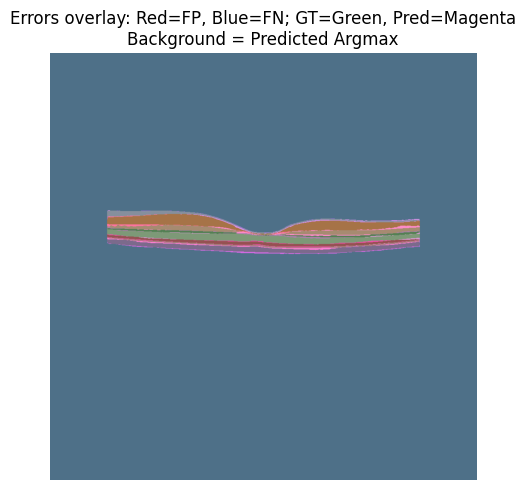

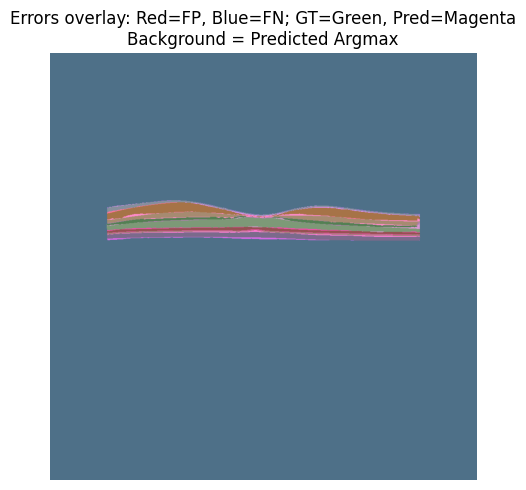

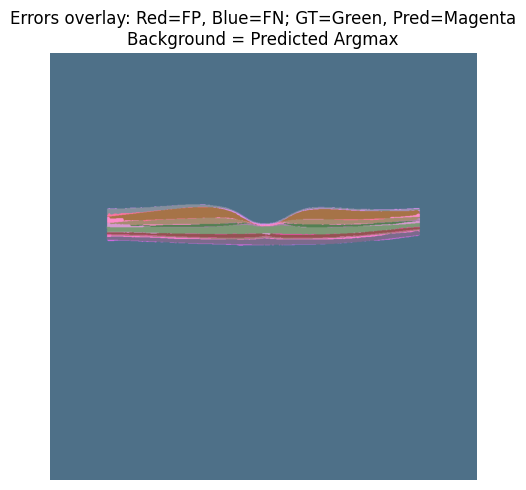

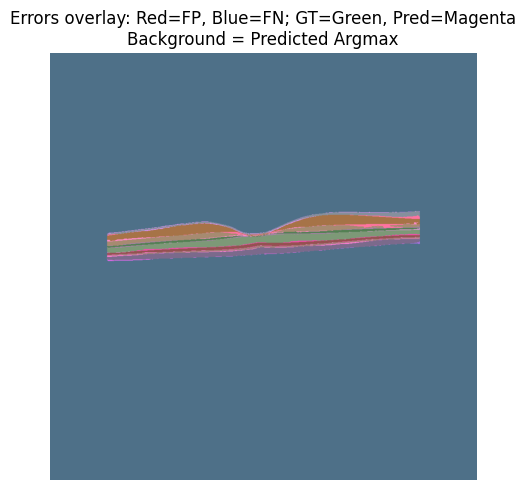

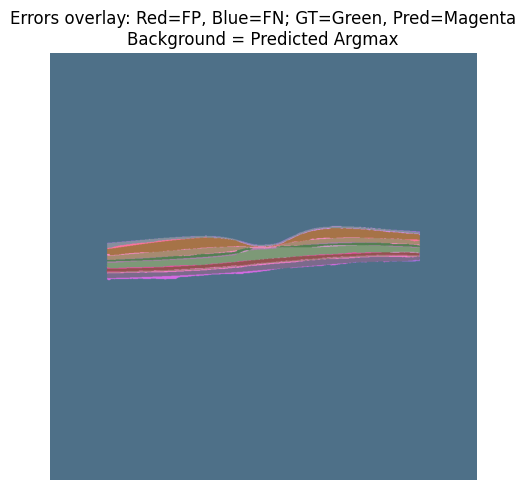

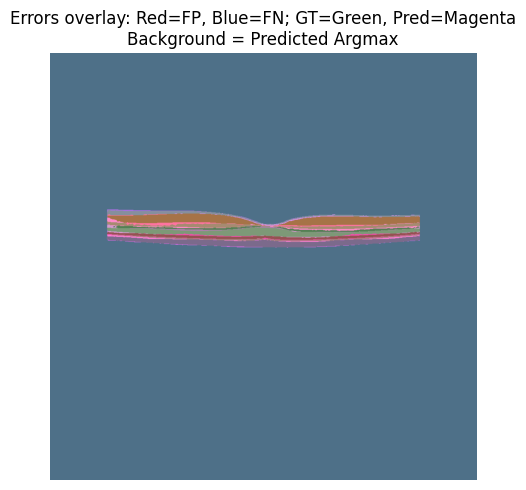

In [3]:
# ==== Full-dataset diagnostics (accumulate over the whole val set) ====

import numpy as np
import torch.nn.functional as F
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap




def _edges(label_2d: np.ndarray):
    """Cheap label boundary map."""
    e = np.zeros_like(label_2d, dtype=bool)
    e[:-1, :] |= (label_2d[:-1, :] != label_2d[1:, :])
    e[:, :-1] |= (label_2d[:, :-1] != label_2d[:, 1:])
    return e



# ---- A few error overlays (FP=red, FN=blue), plus GT( green ) & Pred( magenta ) boundaries ----
base_cmap = ListedColormap(plt.cm.tab20.colors[:K])

def show_overlay(pred, gt):
    H, W = pred.shape
    valid = (gt != IGNORE_INDEX) & ~np.isnan(gt)
    # overlay channels
    overlay = np.zeros((H, W, 3), dtype=np.float32)
    wrong = (pred != gt) & valid
    overlay[..., 0][wrong] = 1.0  # red for FP wrt predicted class
    overlay[..., 2][wrong] = 1.0  # blue for FN wrt true class

    edge_gt   = _edges(gt)
    edge_pred = _edges(pred)

    fig, ax = plt.subplots(figsize=(9, 5))
    ax.imshow(pred, cmap=base_cmap, alpha=0.6)
    ax.imshow(overlay, alpha=0.35)

    yg, xg = np.where(edge_gt)
    ax.scatter(xg, yg, s=0.1, c="lime",    marker="s", linewidths=0, label="GT boundary")
    yp, xp = np.where(edge_pred)
    ax.scatter(xp, yp, s=0.1, c="magenta", marker="s", linewidths=0, label="Pred boundary")
    ax.set_title("Errors overlay: Red=FP, Blue=FN; GT=Green, Pred=Magenta\nBackground = Predicted Argmax")
    ax.axis("off")
    plt.tight_layout()
    plt.show()

if len(example_overlays):
    print(f"\nShowing {min(N_OVERLAYS, len(example_overlays))} example overlays from the val set:")
    for _, gt_ex, pred_ex  in example_overlays[:N_OVERLAYS]:
        show_overlay(pred_ex, gt_ex)




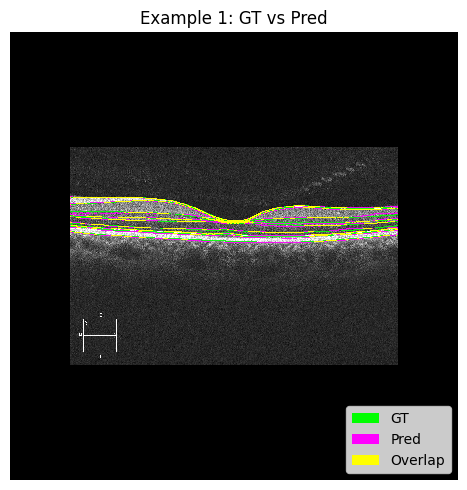

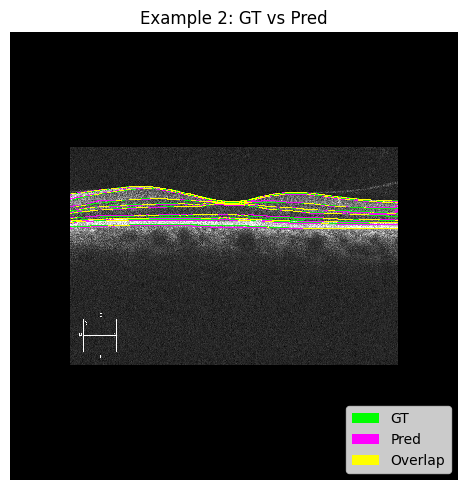

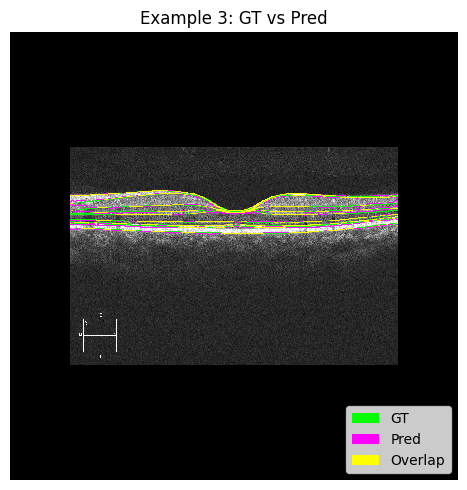

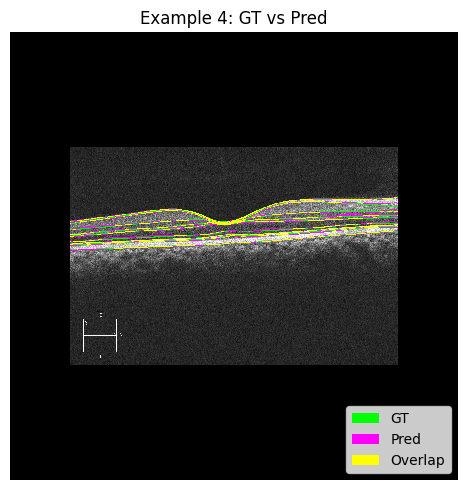

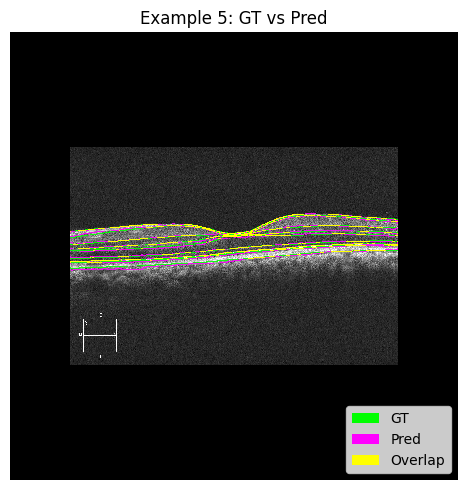

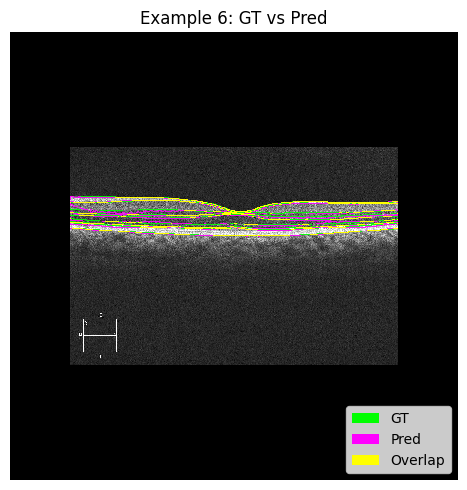

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
try:
    from scipy.ndimage import binary_dilation
    _HAS_DILATION = True
except Exception:
    _HAS_DILATION = False

IGNORE_INDEX = -1  # keep consistent with your dataset

def edges8(label: np.ndarray, valid: np.ndarray | None = None) -> np.ndarray:
    """
    8-connected boundaries for integer label map.
    Returns a 1-px boolean edge map with no wrap-around artifacts,
    masking out invalid pixels if 'valid' is provided.
    """
    H, W = label.shape
    if valid is None:
        valid = np.ones((H, W), dtype=bool)

    e = np.zeros((H, W), dtype=bool)

    # vertical
    e[1: , :] |= (label[1: , :] != label[:-1, :]) & valid[1: , :] & valid[:-1, :]
    e[:-1, :] |= (label[:-1, :] != label[1: , :]) & valid[:-1, :] & valid[1: , :]

    # horizontal
    e[:, 1: ] |= (label[:, 1: ] != label[:, :-1]) & valid[:, 1: ] & valid[:, :-1]
    e[:, :-1] |= (label[:, :-1] != label[:, 1: ]) & valid[:, :-1] & valid[:, 1: ]

    # diagonals
    e[1: , 1: ] |= (label[1: , 1: ] != label[:-1, :-1]) & valid[1: , 1: ] & valid[:-1, :-1]
    e[:-1, :-1] |= (label[:-1, :-1] != label[1: , 1: ]) & valid[:-1, :-1] & valid[1: , 1: ]

    e[1: , :-1] |= (label[1: , :-1] != label[:-1, 1: ]) & valid[1: , :-1] & valid[:-1, 1: ]
    e[:-1, 1: ] |= (label[:-1, 1: ] != label[1: , :-1]) & valid[:-1, 1: ] & valid[1: , :-1]

    return e

def _dilate_np(mask: np.ndarray, thickness: int) -> np.ndarray:
    if thickness <= 1: 
        return mask
    out = mask.copy()
    for _ in range(thickness - 1):
        out = (out |
               np.roll(out, 1, 0) | np.roll(out, -1, 0) |
               np.roll(out, 1, 1) | np.roll(out, -1, 1) |
               np.roll(out, (1,1), (0,1)) | np.roll(out, (-1,-1), (0,1)) |
               np.roll(out, (1,-1), (0,1)) | np.roll(out, (-1,1), (0,1)))
        # clear wrap-around artifacts
        out[0,:] = out[-1,:] = out[:,0] = out[:,-1] = out[0,:] | out[-1,:] | out[:,0] | out[:,-1]
    return out

def show_overlay(img_uint8, gt, pred, title=None, *, thickness=1, alpha=0.9, show_overlap=True):
    H, W = gt.shape
    valid = (gt != IGNORE_INDEX) & np.isfinite(gt)

    gt_e   = edges8(gt,   valid)
    pred_e = edges8(pred, valid)

    if thickness > 1:
        if _HAS_DILATION:
            se = np.ones((thickness, thickness), dtype=bool)
            gt_e   = binary_dilation(gt_e, structure=se)
            pred_e = binary_dilation(pred_e, structure=se)
        else:
            gt_e   = _dilate_np(gt_e, thickness)
            pred_e = _dilate_np(pred_e, thickness)

    both    = gt_e & pred_e
    only_gt = gt_e & ~pred_e
    only_pr = pred_e & ~gt_e

    overlay = np.zeros((H, W, 4), dtype=np.float32)
    overlay[only_gt, 0:3] = (0.0, 1.0, 0.0); overlay[only_gt, 3] = alpha      # green
    overlay[only_pr, 0:3] = (1.0, 0.0, 1.0); overlay[only_pr, 3] = alpha      # magenta
    if show_overlap:
        overlay[both, 0:3] = (1.0, 1.0, 0.0); overlay[both, 3] = 1.0          # yellow

    fig, ax = plt.subplots(figsize=(8, 5))
    ax.imshow(img_uint8, interpolation='none', zorder=1)
    ax.imshow(overlay,  interpolation='none', zorder=2)
    ax.set_title(title or "GT (green) vs Pred (magenta) boundaries (overlap = yellow)")
    ax.axis("off")

    handles = []
    if only_gt.any(): handles.append(Patch(facecolor=(0,1,0), edgecolor='none', label='GT'))
    if only_pr.any(): handles.append(Patch(facecolor=(1,0,1), edgecolor='none', label='Pred'))
    if show_overlap and both.any(): handles.append(Patch(facecolor=(1,1,0), edgecolor='none', label='Overlap'))
    if handles: ax.legend(handles=handles, loc="lower right")
    plt.tight_layout(); plt.show()


# usage
for idx, (raw_img, gt_ex, pred_ex) in enumerate(example_overlays[:N_OVERLAYS]):
    show_overlay(raw_img, gt_ex, pred_ex, title=f"Example {idx+1}: GT vs Pred", thickness=1, alpha=0.9)


## Test smaller images

In [ ]:
from pathlib import Path
from PIL import Image, ImageOps
import torch
import torchvision.transforms.functional as TF

# --- constants ---
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD  = [0.229, 0.224, 0.225]

image_path  = Path(r"D:\GitHub\segment_anything_private\processed_data\Healthy\train\img_unchanged\NORMAL1.png")
image = Image.open(image_path).convert("RGB")
image_resized=image
# image_resized = image.resize((1024, 1024), resample=Image.Resampling.BILINEAR)



# --- zero-pad to 1024×1024 ---
target_size = (1024, 1024)
w, h = image.size
pad_left   = (target_size[0] - w) // 2
pad_top    = (target_size[1] - h) // 2
pad_right  = target_size[0] - w - pad_left
pad_bottom = target_size[1] - h - pad_top

# Pad with zeros (black)
image_padded = ImageOps.expand(image_resized, border=(pad_left, pad_top, pad_right, pad_bottom), fill=0)

# --- convert to tensor and normalize ---
image_tensor = TF.to_tensor(image_padded).unsqueeze(0).to("cuda")
image_tensor = TF.normalize(image_tensor, IMAGENET_MEAN, IMAGENET_STD)


print(image_tensor.shape)



backbone_out = model.forward_image(image_tensor)
_, vision_feats, _, feat_sizes = model._prepare_backbone_features(backbone_out)

batch_size = images.size(0)
if len(vision_feats) > 1:
    vision_feats[-1] = vision_feats[-1] + model.no_mem_embed
    high_res_features = [
        feat.permute(1, 2, 0).reshape(batch_size, feat.size(2), *size)
        for feat, size in zip(vision_feats[:-1], feat_sizes[:-1])
    ]
else:
    high_res_features = None
fused_features = vision_feats[-1].permute(1, 2, 0).reshape(
    batch_size, vision_feats[-1].size(2), *feat_sizes[-1]
)
sam_outputs = model._forward_sam_heads(
    backbone_features=fused_features,
    point_inputs=None,
    mask_inputs=None,
    high_res_features=high_res_features,
    multimask_output=False,
)
_, high_res_multimasks, _, _, _, _, _ = sam_outputs




torch.Size([1, 3, 1024, 1024])


In [ ]:
print(backbone_out.keys())

print(backbone_out['vision_features'].shape)
print(len(backbone_out['vision_pos_enc']))
print(len(backbone_out['backbone_fpn']))

print((backbone_out['vision_pos_enc'][0].shape))
print((backbone_out['backbone_fpn'][0].shape))


dict_keys(['vision_features', 'vision_pos_enc', 'backbone_fpn'])
torch.Size([1, 256, 64, 64])
3
3
torch.Size([1, 256, 256, 256])
torch.Size([1, 32, 256, 256])


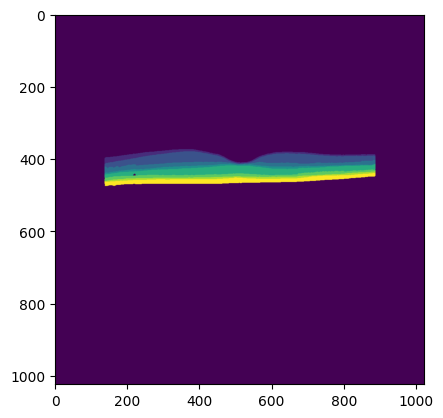

In [ ]:
mask = high_res_multimasks.squeeze(0).detach().cpu().numpy()
argmax_mask = np.argmax(mask, axis=0)  # shape: (H, W)

plt.imshow(argmax_mask)

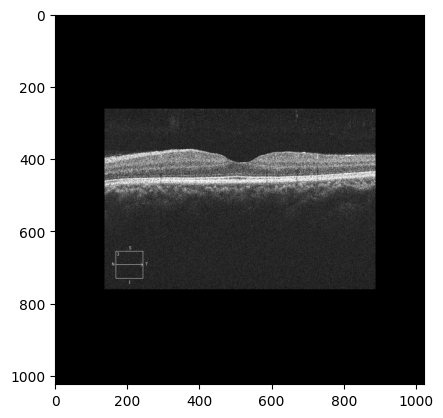

In [ ]:
plt.imshow(image_padded)

### Testing cropping as augmentation

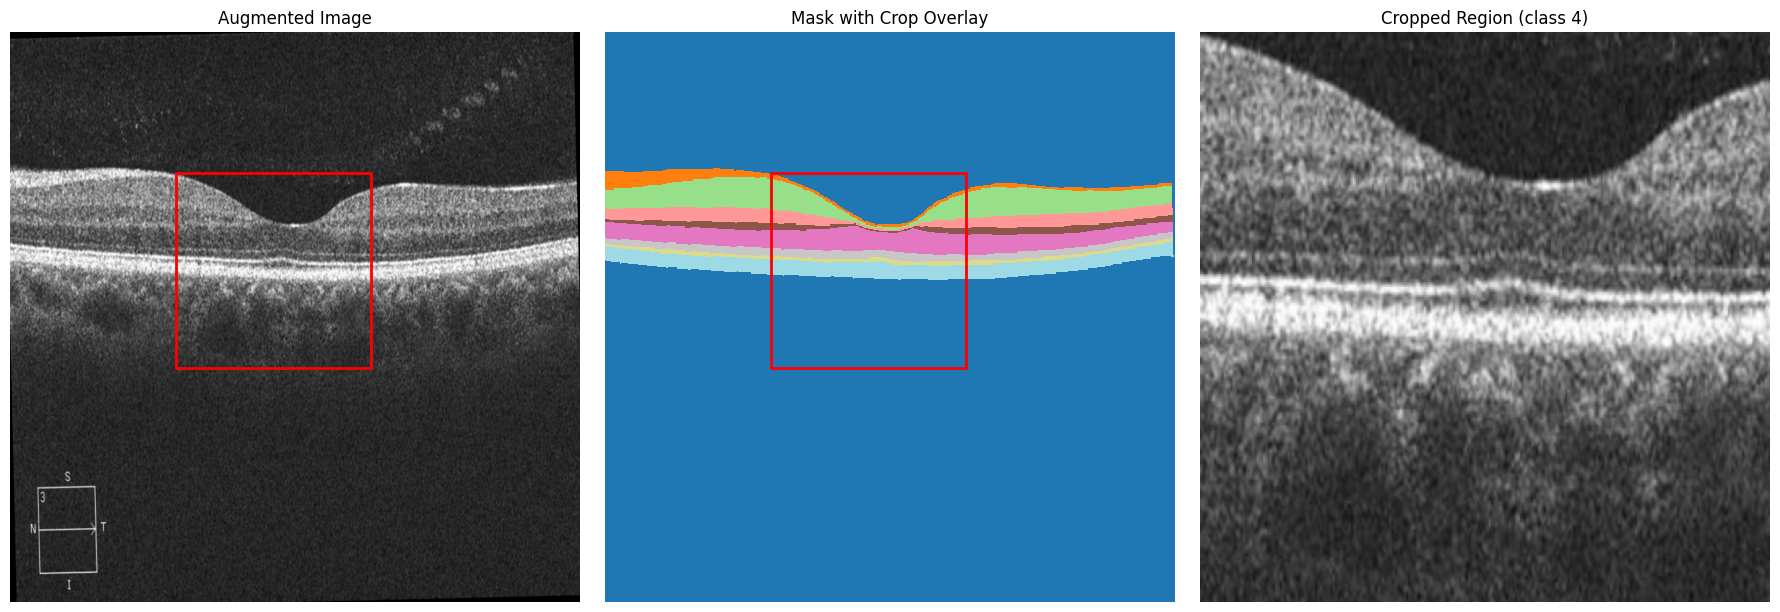

In [ ]:
import random
from typing import Tuple

import albumentations as A
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import cv2
from PIL import Image


# ---------------------------------------------------------------------
# 1. (Optional) joint augmentation. Replace/extend with your pipeline.
# ---------------------------------------------------------------------
rotate_kwargs = {
    "limit": (-5, 5),
    "interpolation": cv2.INTER_LINEAR,
    "border_mode": cv2.BORDER_CONSTANT,
    "crop_border": False,
    "mask_interpolation": cv2.INTER_NEAREST,
    "fill": 0,
    "fill_mask": 0,
    "p": 0.8,
}

joint_aug = A.Compose(
    [
        A.HorizontalFlip(p=0.5),
        A.Rotate(**rotate_kwargs),
        A.AdvancedBlur(
            blur_limit=[3, 7],
            sigma_x_limit=[0.2, 1],
            sigma_y_limit=[0.2, 1],
            rotate_limit=[-90, 90],
            beta_limit=[0.5, 8],
            noise_limit=[0.9, 1.1],
            p=0.8,
        ),
        A.ColorJitter(
            brightness=[0.8, 1.2],
            contrast=[0.8, 1.2],
            saturation=[0.8, 1.2],
            hue=[-0.5, 0.5],
            p=0.8,
        )

    ],
    additional_targets={"mask": "mask"},
)


def apply_joint_aug(image: np.ndarray, mask: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    augmented = joint_aug(image=image, mask=mask)
    return augmented["image"], augmented["mask"]


# ---------------------------------------------------------------------
# 2–3. Crop sampler with guaranteed padding zone.
# ---------------------------------------------------------------------
def sample_padded_crop(
    mask: np.ndarray,
    target_class: int,
    background_class: int = 0,
    min_margin: int = 123,
    min_crop: int = 256,
    extra_margin: int = 10,
    max_attempts: int = 50,
    extra_down: int = 10
) -> Tuple[int, int, int, int]:
    """
    Returns (top, bottom, left, right) indices describing a square crop.
    The crop contains the chosen class region plus padding, fits inside the image,
    and is at least `min_crop` pixels wide/tall.
    """
    h, w = mask.shape[:2]
    coords = np.argwhere(mask == target_class)

    # Filter points that are too close to the border.
    valid = [
        (y, x)
        for y, x in coords
        if (min_margin <= y < h - min_margin) and (min_margin <= x < w - min_margin)
    ]
    if not valid:
        raise ValueError("No candidate pixels satisfy the margin constraint.")

    for _ in range(max_attempts):
        center_y, center_x = random.choice(valid)

        # Step upward until we hit background or exit.
        up = center_y
        while up >= 0 and mask[up, center_x] != background_class:
            up -= 1

        # Step downward similarly.
        down = center_y
        while down < h and mask[down, center_x] != background_class:
            down += 1

        # If background not found on either side before hitting the edge, try a new point.
        if up < 0 or down >= h:
            continue

        # Height of the non-background band plus requested cushion.
        band_height = down - up - 1  # excludes the background rows themselves
        crop_size = max(band_height + extra_margin + extra_down, min_crop)
        crop_size = min(crop_size, min(h, w))  # keep square inside the image

        if crop_size < min_crop:
            continue  # image too small; pick another point

        # Compute vertical placement: crop must contain the entire band.
        band_top = up + 1
        band_bottom = down - 1
        top_low = max(band_bottom + 1 - crop_size, 0)
        top_high = min(band_top, h - crop_size)
        if top_low > top_high:
            continue  # this crop size can't cover the band

        top = int(np.clip(center_y - crop_size // 2 + extra_down, top_low, top_high))
        bottom = top + crop_size + extra_down

        # Horizontal placement: keep the chosen x near the center but shift if near edges.
        left = int(np.clip(center_x - (crop_size+extra_down) // 2, 0, w - crop_size))
        right = left + crop_size + extra_down

        return top, bottom, left, right

    raise RuntimeError("Failed to sample a valid crop after multiple attempts.")


def crop_image_and_mask(
    image: np.ndarray, mask: np.ndarray, bounds: Tuple[int, int, int, int]
) -> Tuple[np.ndarray, np.ndarray]:
    top, bottom, left, right = bounds
    return image[top:bottom, left:right], mask[top:bottom, left:right]


# ---------------------------------------------------------------------
# 4. Visualization helper.
# ---------------------------------------------------------------------
def visualize_crop(
    image: np.ndarray,
    mask: np.ndarray,
    crop_bounds: Tuple[int, int, int, int],
    target_class: int,
):
    top, bottom, left, right = crop_bounds

    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    axes[0].imshow(image)
    axes[0].set_title("Augmented Image")
    axes[0].add_patch(
        patches.Rectangle(
            (left, top),
            right - left,
            bottom - top,
            linewidth=2,
            edgecolor="red",
            facecolor="none",
        )
    )
    axes[0].set_axis_off()

    axes[1].imshow(mask, cmap="tab20", interpolation="nearest")
    axes[1].set_title("Mask with Crop Overlay")
    axes[1].add_patch(
        patches.Rectangle(
            (left, top),
            right - left,
            bottom - top,
            linewidth=2,
            edgecolor="red",
            facecolor="none",
        )
    )
    axes[1].set_axis_off()

    cropped_img, cropped_mask = crop_image_and_mask(image, mask, crop_bounds)
    axes[2].imshow(cropped_img)
    axes[2].set_title(f"Cropped Region (class {target_class})")
    axes[2].set_axis_off()

    fig.tight_layout()
    plt.show()


# ---------------------------------------------------------------------
# Example usage (replace with your own loader).
# ---------------------------------------------------------------------
if __name__ == "__main__":
    # Dummy data for illustration; load your real image/mask here.
    H, W = 1024, 1024

    image = Image.open("D:/GitHub/segment_anything_private/processed_data/Healthy/val/img_stretched/NORMAL129.png")
    image = np.array(image.convert("RGB"))
    mask = Image.open("D:/GitHub/segment_anything_private/processed_data/Healthy/val/mask_stretched/NORMAL129.png")
    mask = np.array(mask, dtype=np.int32)

    # 1. augment (optional)
    aug_img, aug_mask = apply_joint_aug(image, mask)

    # 2–3. sample padded crop focused on class 4
    bounds = sample_padded_crop(
        aug_mask,
        target_class=4,
        background_class=0,
        min_margin=123,
        min_crop=256,
        extra_margin=150,
        extra_down=50
    )

    # 4. visualize
    visualize_crop(aug_img, aug_mask, bounds, target_class=4)


### Cropping for validation

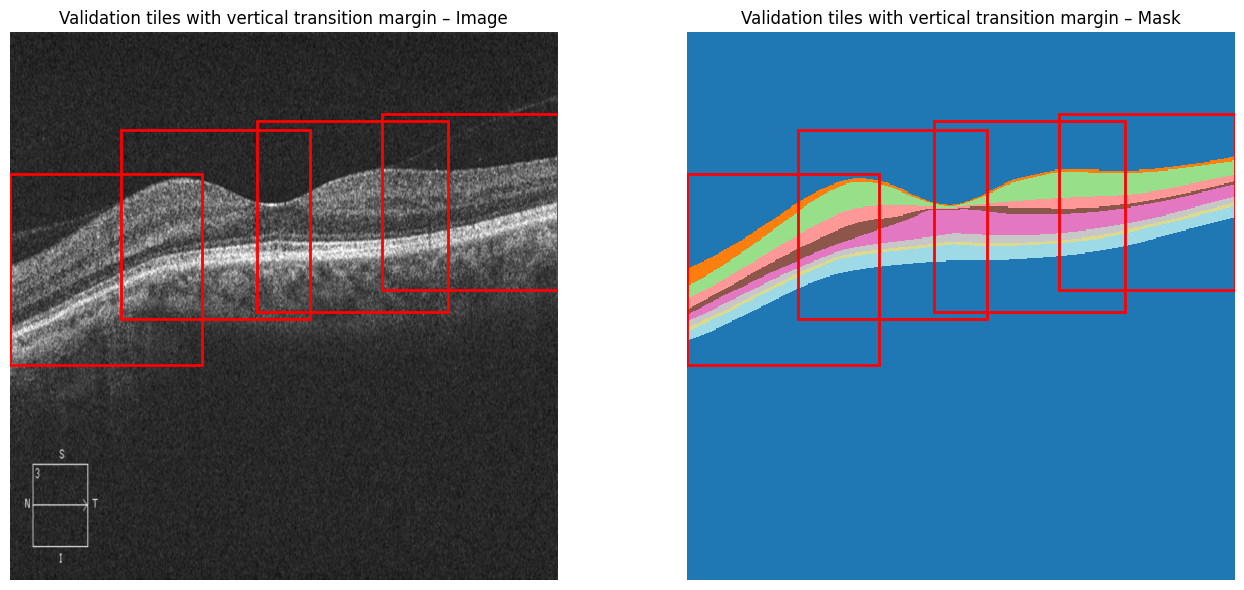

Created 4 crops.


In [ ]:
from typing import List, Tuple
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# -----------------------------
# Helpers (updated/new)
# -----------------------------
def _class_x_extent(mask: np.ndarray, cls: int) -> Tuple[int, int]:
    cols_with_cls = np.where(np.any(mask == cls, axis=0))[0]
    if cols_with_cls.size == 0:
        raise ValueError(f"Class {cls} not present in mask.")
    return int(cols_with_cls.min()), int(cols_with_cls.max())


def _median_y_at_x(mask: np.ndarray, cls: int, x: int, search_radius: int = 8) -> int:
    H, W = mask.shape
    if 0 <= x < W:
        ys = np.where(mask[:, x] == cls)[0]
        if ys.size > 0:
            return int(np.median(ys))
    for r in range(1, search_radius + 1):
        for xx in (x - r, x + r):
            if 0 <= xx < W:
                ys = np.where(mask[:, xx] == cls)[0]
                if ys.size > 0:
                    return int(np.median(ys))
    ys_all, xs_all = np.where(mask == cls)
    if ys_all.size > 0:
        return int(np.median(ys_all))
    raise ValueError(f"No pixels found for class {cls} anywhere in the mask.")


def _vertical_band_with_margin(
    mask: np.ndarray,
    cx: int,
    search_radius: int = 8,
    background_class: int = 0,
    extra_margin: int = 32,
) -> Tuple[int, int]:
    """
    Around column `cx` (±search_radius), find the contiguous non-background (mask != 0)
    band spanning those columns, then expand by `extra_margin` on both sides.
    Returns (desired_top, desired_bottom), clamped to image bounds.
    """
    H, W = mask.shape
    cols = [c for c in range(cx - search_radius, cx + search_radius + 1) if 0 <= c < W]

    # Per column, find top-most and bottom-most nonzero (non-background) pixels
    tops = []
    bottoms = []
    for c in cols:
        ys = np.where(mask[:, c] != background_class)[0]
        if ys.size > 0:
            tops.append(int(ys.min()))
            bottoms.append(int(ys.max()))

    if not tops:
        # Fallback: no nonzero found nearby; default to full height
        band_top, band_bottom = 0, H - 1
    else:
        band_top, band_bottom = min(tops), max(bottoms)

    # Expand by extra_margin and clamp
    top_desired = max(0, band_top - extra_margin)
    bottom_desired = min(H - 1, band_bottom + extra_margin)
    return top_desired, bottom_desired


def build_validation_crops(
    mask: np.ndarray,
    target_class: int = 4,
    min_crop: int = 256,
    start_offset: int = 123,
    step: int = 256,
    extra_margin: int = 32,
    search_radius: int = 8,
) -> List[Tuple[int, int, int, int]]:
    """
    Produce square crops that cover the horizontal extent of `target_class`.
    Each crop is vertically expanded so the nearest class→background transition
    is at least `extra_margin` inside the crop (top/bottom).
    """
    H, W = mask.shape
    xL, xR = _class_x_extent(mask, target_class)

    # First center x
    cx = int(np.clip(xL + start_offset, min_crop // 2, W - (min_crop - min_crop // 2)))
    boxes: List[Tuple[int, int, int, int]] = []

    while True:
        # Representative vertical position (for centering if needed)
        cy = _median_y_at_x(mask, target_class, cx, search_radius=search_radius)

        # Find vertical band around cx (±search_radius), then expand by extra_margin
        band_top, band_bottom = _vertical_band_with_margin(
            mask,
            cx=cx,
            search_radius=search_radius,
            background_class=0,
            extra_margin=extra_margin,
        )

        # Required crop height to keep transitions >= extra_margin from edges
        required_h = (band_bottom - band_top + 1)
        crop_size = max(min_crop, required_h)
        crop_size = min(crop_size, min(H, W))  # keep square inside image

        # Center vertically on the band (or cy), then clamp
        band_center = (band_top + band_bottom) / 2.0
        top = int(np.clip(int(round(band_center - crop_size / 2)), 0, H - crop_size))
        bottom = top + crop_size

        # Horizontal placement: center at cx, clamp to image
        left = int(np.clip(int(round(cx - crop_size / 2)), 0, W - crop_size))
        right = left + crop_size

        boxes.append((top, bottom, left, right))

        # Stop when the last box reaches beyond the class's rightmost extent
        if right >= min(W, xR + min_crop // 2):
            break

        cx += step
        if len(boxes) > 64:  # safety
            break

    return boxes


def extract_crops(
    image: np.ndarray,
    mask: np.ndarray,
    boxes: List[Tuple[int, int, int, int]],
) -> List[Tuple[np.ndarray, np.ndarray]]:
    crops = []
    for (t, b, l, r) in boxes:
        crops.append((image[t:b, l:r], mask[t:b, l:r]))
    return crops


def visualize_boxes(image: np.ndarray, mask: np.ndarray, boxes: List[Tuple[int, int, int, int]], title="Validation tiles"):
    import matplotlib.pyplot as plt
    import matplotlib.patches as patches

    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    axes[0].imshow(image)
    axes[0].set_title(f"{title} – Image")
    axes[0].set_axis_off()

    axes[1].imshow(mask, cmap="tab20", interpolation="nearest")
    axes[1].set_title(f"{title} – Mask")
    axes[1].set_axis_off()

    for (t, b, l, r) in boxes:
        rect_img = patches.Rectangle((l, t), r - l, b - t, linewidth=2, edgecolor="red", facecolor="none")
        rect_msk = patches.Rectangle((l, t), r - l, b - t, linewidth=2, edgecolor="red", facecolor="none")
        axes[0].add_patch(rect_img)
        axes[1].add_patch(rect_msk)

    plt.tight_layout()
    plt.show()


# -----------------------------
# Example usage
# -----------------------------
if __name__ == "__main__":
    img_path  = r"D:\GitHub\segment_anything_private\processed_data\Healthy\train\img_stretched\NORMAL27.png"
    mask_path = r"D:\GitHub\segment_anything_private\processed_data\Healthy\train\mask_stretched\NORMAL27.png"

    image = np.array(Image.open(img_path).convert("RGB"))
    mask  = np.array(Image.open(mask_path), dtype=np.int32)

    boxes = build_validation_crops(
        mask,
        target_class=4,
        min_crop=256,
        start_offset=123,
        step=256,
        extra_margin=100,     # <- NEW: ensure transitions are this far inside the crop
        search_radius=8
    )

    visualize_boxes(image, mask, boxes, title="Validation tiles with vertical transition margin")
    val_crops = extract_crops(image, mask, boxes)
    print(f"Created {len(val_crops)} crops.")


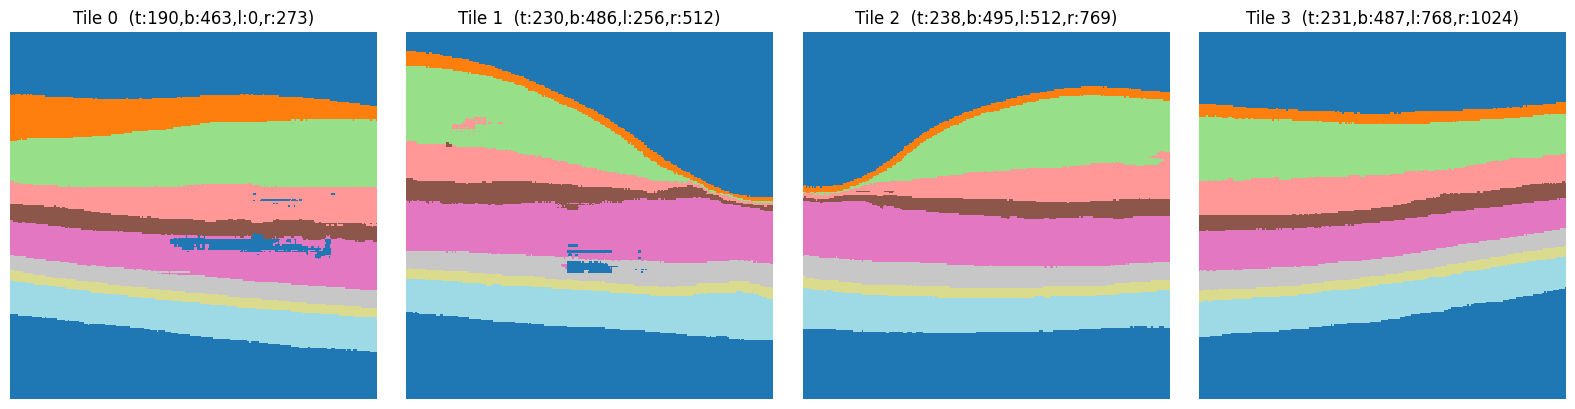

In [ ]:
# ---- Add these imports with your existing ones ----
import torch.nn.functional as F
from typing import List, Tuple
import numpy as np
from PIL import Image
import math

from setup_imports import root_dir
from torch.utils.data import DataLoader, Dataset
from pathlib import Path
from typing import Dict, Optional
from PIL import Image
import torch
import random
import torchvision.transforms.functional as TF
import numpy as np
import matplotlib.pyplot as plt

from semantic_sam2.build_semantic_sam2 import build_semantic_sam2

# -----------------------------
# A) Helpers: tiling from binary (foreground vs background) with vertical margin
# -----------------------------
def _x_extent_from_binary(mask01: np.ndarray) -> Tuple[int, int]:
    cols = np.where(np.any(mask01 != 0, axis=0))[0]
    if cols.size == 0:
        raise ValueError("No foreground found in binary mask.")
    return int(cols.min()), int(cols.max())

def _vertical_band_with_margin_from_binary(
    mask01: np.ndarray,
    cx: int,
    search_radius: int = 8,
    extra_margin: int = 48,
) -> Tuple[int, int]:
    H, W = mask01.shape
    cols = [c for c in range(cx - search_radius, cx + search_radius + 1) if 0 <= c < W]

    tops, bottoms = [], []
    for c in cols:
        ys = np.where(mask01[:, c] != 0)[0]
        if ys.size > 0:
            tops.append(int(ys.min()))
            bottoms.append(int(ys.max()))

    if not tops:
        band_top, band_bottom = 0, H - 1
    else:
        band_top, band_bottom = min(tops), max(bottoms)

    top = max(0, band_top - extra_margin)
    bottom = min(H - 1, band_bottom + extra_margin)
    return top, bottom

def build_validation_crops_from_binary(
    mask01: np.ndarray,
    *,
    min_crop: int = 256,
    start_offset: int = 123,
    step: int = 256,
    extra_margin: int = 48,
    search_radius: int = 8,
) -> List[Tuple[int, int, int, int]]:
    """
    Return list of square (top, bottom, left, right) boxes spanning horizontally across foreground.
    Each crop is vertically expanded so the nearest 1→0 transition is >= extra_margin inside.
    """
    H, W = mask01.shape
    xL, xR = _x_extent_from_binary(mask01)

    cx = int(np.clip(xL + start_offset, min_crop // 2, W - (min_crop - min_crop // 2)))
    boxes: List[Tuple[int, int, int, int]] = []

    while True:
        band_top, band_bottom = _vertical_band_with_margin_from_binary(
            mask01, cx, search_radius=search_radius, extra_margin=extra_margin
        )

        required_h = (band_bottom - band_top + 1)
        crop_size = max(min_crop, required_h)
        crop_size = min(crop_size, min(H, W))

        cy = (band_top + band_bottom) / 2.0
        top = int(np.clip(int(round(cy - crop_size / 2)), 0, H - crop_size))
        bottom = top + crop_size

        left = int(np.clip(int(round(cx - crop_size / 2)), 0, W - crop_size))
        right = left + crop_size

        boxes.append((top, bottom, left, right))

        if right >= min(W, xR + min_crop // 2):
            break

        cx += step
        if len(boxes) > 64:  # safety
            break

    return boxes

# -----------------------------
# B) Model wrappers (using your working path)
# -----------------------------
@torch.no_grad()
def infer_full_logits_1024(model, images_1x3x1024x1024: torch.Tensor) -> torch.Tensor:
    """
    Your path returns logits with shape (1, 9, 1024, 1024).
    """
    model.eval()
    backbone_out = model.forward_image(images_1x3x1024x1024)
    _, vision_feats, _, feat_sizes = model._prepare_backbone_features(backbone_out)

    B = images_1x3x1024x1024.size(0)
    if len(vision_feats) > 1:
        high_res_features = [
            feat.permute(1, 2, 0).reshape(B, feat.size(2), *size)
            for feat, size in zip(vision_feats[:-1], feat_sizes[:-1])
        ]
    else:
        high_res_features = None

    fused_features = vision_feats[-1].permute(1, 2, 0).reshape(
        B, vision_feats[-1].size(2), *feat_sizes[-1]
    )
    sam_outputs = model._forward_sam_heads(
        backbone_features=fused_features,
        point_inputs=None,
        mask_inputs=None,
        high_res_features=high_res_features,
        multimask_output=False,
    )
    # You stated this is logits with shape (1, 9, 1024, 1024)
    logits_1xKxHxW = sam_outputs[1]
    return logits_1xKxHxW

def _to_uint8_np(img_1x3xHxW_norm: torch.Tensor) -> np.ndarray:
    """
    Convert a normalized PyTorch tensor (1,3,H,W) with ImageNet norm back to uint8 HxWx3.
    """
    t = img_1x3xHxW_norm[0].cpu()
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
    std  = torch.tensor([0.229, 0.224, 0.225]).view(3,1,1)
    t = (t * std + mean).clamp(0,1)
    return (t.permute(1,2,0).numpy() * 255).astype(np.uint8)

def _from_uint8_np(img_uint8: np.ndarray) -> torch.Tensor:
    """
    Convert uint8 HxWx3 -> normalized (1,3,H,W) float tensor with ImageNet norm.
    """
    t = torch.from_numpy(img_uint8).float() / 255.0  # H,W,3
    t = t.permute(2,0,1)  # 3,H,W
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
    std  = torch.tensor([0.229, 0.224, 0.225]).view(3,1,1)
    t = (t - mean) / std
    return t.unsqueeze(0)  # 1,3,H,W

import math
import matplotlib.pyplot as plt

# -----------------------------
# C) End-to-end tiling + recombine (with per-tile argmax capture/plot)
# -----------------------------
@torch.no_grad()
def segment_with_tiling_using_fullmask_boxes(
    model,
    image_1x3x1024x1024: torch.Tensor,
    *,
    num_classes: int = 9,
    min_crop: int = 256,
    start_offset: int = 123,
    step: int = 256,
    extra_margin: int = 48,
    search_radius: int = 8,
    crop_inference_size: int = 512,   # choose 256/512/1024 depending on speed/accuracy needs
    device: torch.device = torch.device("cuda" if torch.cuda.is_available() else "cpu"),
    collect_tile_preds: bool = True,
    plot_tile_preds: bool = False,
) -> Dict[str, np.ndarray]:
    """
    1) Full-image logits -> softmax/argmax -> class mask (0..K-1)
    2) Binary (0 vs rest) -> boxes (with vertical extra_margin)
    3) Per-crop logits (resized inference) -> paste (max-logit blend)
    4) Final argmax -> 1024x1024 mask

    Additionally:
    - Captures argmax per crop (after upsampling logits back to crop size).
    - Optionally plots a grid of tile argmax masks for debugging.
    """
    H = W = 1024  # as per your setup

    # 1) Full-image prediction
    logits_full = infer_full_logits_1024(model, image_1x3x1024x1024.to(device))  # (1,K,1024,1024)
    probs_full  = F.softmax(logits_full, dim=1)
    pred_full   = probs_full.argmax(dim=1)[0].cpu().numpy().astype(np.int64)     # (1024,1024)

    # 2) Build boxes from binary (0 vs rest)
    binary = (pred_full != 0).astype(np.uint8)
    boxes = build_validation_crops_from_binary(
        binary,
        min_crop=min_crop,
        start_offset=start_offset,
        step=step,
        extra_margin=extra_margin,
        search_radius=search_radius,
    )

    # Prepare canvas for logit blending
    canvas_logits = torch.full((num_classes, H, W), -1e9, dtype=torch.float32, device=device)

    # Convert input back to uint8 to crop easily
    img_uint8 = _to_uint8_np(image_1x3x1024x1024)

    # For debugging / inspection
    tile_pred_masks: List[np.ndarray] = []

    # 3) For each crop: run model, upsample to crop size, capture argmax, paste via max
    for (t, b, l, r) in boxes:
        crop_rgb = img_uint8[t:b, l:r, :]  # Hc x Wc x 3

        # Resize crop for inference (square -> crop_inference_size)
        if (b - t) != crop_inference_size:
            crop_resized = np.array(
                Image.fromarray(crop_rgb).resize((crop_inference_size, crop_inference_size), Image.BILINEAR)
            )
        else:
            crop_resized = crop_rgb

        x_crop = _from_uint8_np(crop_resized).to(device)

        # Inference on crop (returns (1,K,h,w))
        logits_crop = infer_full_logits_1024(model, x_crop)

        # Upsample logits back to original crop size
        logits_up = F.interpolate(
            logits_crop, size=(b - t, r - l), mode="bilinear", align_corners=False
        )[0]  # (K, Hc, Wc)

        # === DEBUG: capture per-tile argmax at native crop size ===
        if collect_tile_preds:
            tile_pred = logits_up.argmax(dim=0).cpu().numpy().astype(np.int64)  # (Hc, Wc)
            tile_pred_masks.append(tile_pred)

        # Blend with max to avoid seams in overlaps (if any)
        canvas_logits[:, t:b, l:r] = torch.maximum(canvas_logits[:, t:b, l:r], logits_up)

    # 4) Final argmax over blended logits
    pred_tiled = canvas_logits.argmax(dim=0).cpu().numpy().astype(np.int64)  # (1024,1024)

    # Optional plotting of per-tile predictions
    if plot_tile_preds and len(tile_pred_masks) > 0:
        n = len(tile_pred_masks)
        cols = min(4, n)
        rows = math.ceil(n / cols)
        fig, axes = plt.subplots(rows, cols, figsize=(4*cols, 4*rows))
        axes = np.atleast_2d(axes)
        for i, pred in enumerate(tile_pred_masks):
            r_i, c_i = divmod(i, cols)
            ax = axes[r_i, c_i]
            ax.imshow(pred, cmap="tab20", interpolation="nearest")
            t, b, l, r = boxes[i]
            ax.set_title(f"Tile {i}  (t:{t},b:{b},l:{l},r:{r})")
            ax.axis("off")
        # Hide any unused axes
        for j in range(n, rows*cols):
            r_j, c_j = divmod(j, cols)
            axes[r_j, c_j].axis("off")
        plt.tight_layout()
        plt.show()

    return {
        "full_pred_mask": pred_full,          # (1024,1024) from the single full pass
        "binary_mask": binary,                # (1024,1024) 0 vs rest used for tiling
        "boxes": np.array(boxes),             # Nx4 (t,b,l,r)
        "tiled_pred_mask": pred_tiled,        # (1024,1024) recombined mask
        "tile_pred_masks": tile_pred_masks,   # List[(Hc,Wc)] aligned with boxes[i]
        "tile_boxes": np.array(boxes),        # duplicate for convenience
    }


# -----------------------------
# D) Example usage with your DataLoader batch
# -----------------------------
# Using your existing code up to `images` tensor:
# images = batch["image"].to(device, non_blocking=True)  # shape (1,3,1024,1024), normalized



IMAGE_EXTENSIONS = {".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff"}

IMAGENET_MEAN = (0.485, 0.456, 0.406)
IMAGENET_STD = (0.229, 0.224, 0.225)


class PairedImageMaskDataset(Dataset):
    """Dataset that pairs images and masks located in separate directories."""

    def __init__(
        self,
        image_dir: Path,
        mask_dir: Path,
        image_size: int,
        num_classes: Optional[int] = None,
        ignore_index: Optional[int] = None,
        augment: bool = False,
    ) -> None:
        self.image_dir = Path(image_dir)
        self.mask_dir = Path(mask_dir)
        if not self.image_dir.exists():
            raise FileNotFoundError(f"Image directory not found: {self.image_dir}")
        if not self.mask_dir.exists():
            raise FileNotFoundError(f"Mask directory not found: {self.mask_dir}")

        mask_lookup = {}
        mask_candidates = [
            p
            for p in self.mask_dir.rglob("*")
            if p.is_file() and p.suffix.lower() in IMAGE_EXTENSIONS
        ]
        if not mask_candidates:
            raise ValueError(f"No mask files found under {self.mask_dir}")
        for mask_path in mask_candidates:
            stem = mask_path.stem
            if stem in mask_lookup:
                print(
                    "Duplicate mask stem '%s' found; keeping first instance.", stem
                )
                continue
            mask_lookup[stem] = mask_path

        image_candidates = [
            p
            for p in self.image_dir.rglob("*")
            if p.is_file() and p.suffix.lower() in IMAGE_EXTENSIONS
        ]
        if not image_candidates:
            raise ValueError(f"No image files found under {self.image_dir}")

        self.pairs = []
        for image_path in sorted(image_candidates):
            mask_path = mask_lookup.get(image_path.stem)
            if mask_path is None:
                print(
                    "Skipping '%s' because no matching mask was found.", image_path.name
                )
                continue
            self.pairs.append((image_path, mask_path))

        if not self.pairs:
            raise ValueError(
                "No image/mask pairs found. Ensure filenames match between directories."
            )

        self.image_size = image_size
        self.num_classes = num_classes
        self.ignore_index = ignore_index
        self.augment = augment
        resampling = getattr(Image, 'Resampling', None)
        if resampling is not None:
            self._image_resample = resampling.BILINEAR
            self._mask_resample = resampling.NEAREST
        else:
            self._image_resample = Image.BILINEAR
            self._mask_resample = Image.NEAREST

    def __len__(self) -> int:
        return len(self.pairs)

    def __getitem__(self, index: int) -> Dict[str, torch.Tensor]:
        image_path, mask_path = self.pairs[index]
        image = Image.open(image_path).convert("RGB")
        mask = Image.open(mask_path)

        if self.augment:
            if random.random() < 0.5:
                image = TF.hflip(image)
                mask = TF.hflip(mask)
            if random.random() < 0.5:
                image = TF.vflip(image)
                mask = TF.vflip(mask)

        mask = mask.resize((self.image_size, self.image_size), resample=self._mask_resample)
        mask_array = np.array(mask, dtype=np.int64)
        if mask_array.ndim == 3:
            mask_array = mask_array[..., 0]

        mask_tensor = torch.tensor(mask_array, dtype=torch.long)
        if self.num_classes is not None:
            invalid = mask_tensor >= self.num_classes
            if invalid.any():
                if self.ignore_index is not None:
                    mask_tensor[invalid] = self.ignore_index
                else:
                    mask_tensor[invalid] = self.num_classes - 1
        if self.ignore_index is not None:
            negative = mask_tensor < 0
            if negative.any():
                mask_tensor[negative] = self.ignore_index

        image = image.resize((self.image_size, self.image_size), resample=self._image_resample)
        image_tensor = TF.to_tensor(image)
        image_tensor = TF.normalize(image_tensor, IMAGENET_MEAN, IMAGENET_STD)

        return {
            "image": image_tensor,
            "mask": mask_tensor,
            "image_path": str(image_path),
            "mask_path": str(mask_path),
        }
    


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
pin_memory = device.type == "cuda"

hydra_overrides = [
    "++model._target_=semantic_sam2.semantic_sam2_components.SAM2Semantic",
    f"++model.num_classes={9}",
    "++model.num_maskmem=0",
    "++model.use_mask_input_as_output_without_sam=false",
]

sam2_checkpoint = root_dir/"semantic_sam2/training_checkpoints/test_run8_R2_endBest.pt"
# sam2_checkpoint =root_dir/"checkpoints/sam2.1_hiera_base_plus.pt"

model = build_semantic_sam2(
    config_file="configs/sam2.1/sam2.1_hiera_b+.yaml",
    ckpt_path=str(sam2_checkpoint),
    device=str(device),
    mode="eval",
    hydra_overrides_extra=hydra_overrides,
    apply_postprocessing=False,
    use_load_checkpoint_staged_safe=True,
)

model.num_maskmem = 0
model.use_mask_input_as_output_without_sam = False


val_dataset = PairedImageMaskDataset(
    image_dir=Path(r"D:\GitHub\segment_anything_private\processed_data\Healthy\val\img_stretched"),
    mask_dir=Path(r"D:\GitHub\segment_anything_private\processed_data\Healthy\val\mask_stretched"),
    image_size=model.image_size,
    num_classes=9,
    ignore_index=-1,
    augment=False,
)

val_loader = DataLoader(
    val_dataset,
    batch_size=1,
    shuffle=False,
    num_workers=0,
    pin_memory=pin_memory,
    drop_last=False,
)




val_iter = iter(val_loader)
batch = next(val_iter)

images = batch["image"].to(device, non_blocking=True)


results = segment_with_tiling_using_fullmask_boxes(
    model,
    images,                   # (1,3,1024,1024) normalized
    num_classes=9,
    min_crop=256,
    start_offset=123,
    step=256,
    extra_margin=48,
    search_radius=8,
    crop_inference_size=1024,  # try 256 or 1024 depending on speed/accuracy
    device=device,
    plot_tile_preds=True
)

pred_full  = results["full_pred_mask"]     # (1024,1024)
pred_tiled = results["tiled_pred_mask"]    # (1024,1024)
boxes      = results["boxes"]


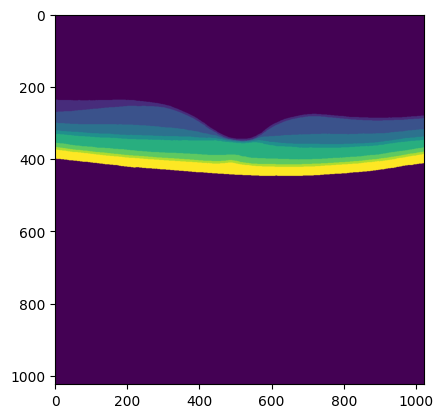

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(pred_full)

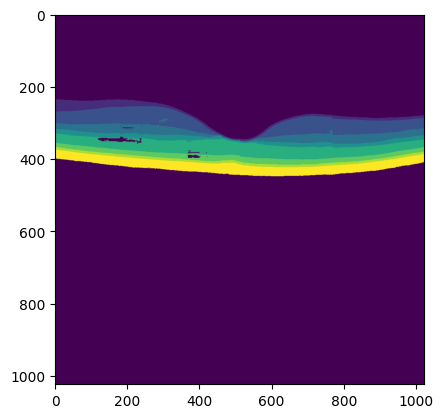

In [ ]:
plt.imshow(pred_tiled)

### Determine my data statistics

In [8]:
from pathlib import Path
from PIL import Image
import numpy as np
from tqdm import tqdm

# --- Path to your image directory ---
image_dir = Path(r"D:\GitHub\segment_anything_private\processed_data\Healthy\val\img_unchanged")

# --- Supported extensions ---
extensions = {".png", ".jpg", ".jpeg", ".bmp", ".tif", ".tiff"}

# --- Collect all image paths ---
image_paths = [p for p in image_dir.rglob("*") if p.suffix.lower() in extensions]
print(f"Found {len(image_paths)} images.")

# --- Initialize accumulators ---
n_pixels = 0
channel_sum = np.zeros(3)
channel_sq_sum = np.zeros(3)

# --- Loop through images ---
for path in tqdm(image_paths, desc="Computing mean/std"):
    img = Image.open(path).convert("RGB")
    img_np = np.array(img, dtype=np.float32) / 255.0  # Scale to [0, 1]
    
    n_pixels += img_np.shape[0] * img_np.shape[1]
    channel_sum += img_np.sum(axis=(0, 1))
    channel_sq_sum += (img_np ** 2).sum(axis=(0, 1))

# --- Compute mean and std ---
mean = channel_sum / n_pixels
std = np.sqrt(channel_sq_sum / n_pixels - mean ** 2)

print(f"Mean: {mean.round(3)}")
print(f"Std:  {std.round(3)}")


Found 40 images.


Computing mean/std: 100%|██████████| 40/40 [00:00<00:00, 71.04it/s]

Mean: [0.238 0.238 0.238]
Std:  [0.168 0.168 0.168]
